# R: DoubleML for Difference-in-Differences

In this example, we demonstrate, how `DoubleML` can be used in combination with the [did package for R](https://bcallaway11.github.io/did/index.html) in order to estimate group-time average treatment effects in difference-in-difference (DiD) models with multiple periods.

In [1]:
library(DoubleML)
library(did)
library(mlr3)
library(mlr3learners)

# suppress messages during fitting
lgr::get_logger("mlr3")$set_threshold("warn")

set.seed(1234)


# Demo Example from `did`

We will demonstrate the use of `DoubleML` for DiD in the [introductory example](https://bcallaway11.github.io/did/articles/did-basics.html) of the `did` package. 

In [2]:
# Generate data, original code available at https://github.com/bcallaway11/did/blob/master/vignettes/did-basics.Rmd
time.periods <- 4
sp <- reset.sim()
sp$te <- 0

set.seed(1814)

# generate dataset with 4 time periods
time.periods <- 4

# add dynamic effects
sp$te.e <- 1:time.periods

# generate data set with these parameters
# here, we dropped all units who are treated in time period 1 as they do not help us recover ATT(g,t)'s.
dta <- build_sim_dataset(sp)

# How many observations remained after dropping the ``always-treated'' units
nrow(dta)
#This is what the data looks like
head(dta)

[1] 15916

G,X,id,cluster,period,Y,treat
<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
3,-0.8762330,1,5,1,5.562556,1
3,-0.8762330,1,5,2,4.349213,1
3,-0.8762330,1,5,3,7.134037,1
3,-0.8762330,1,5,4,6.243056,1
2,-0.8738481,2,36,1,-3.659387,1
2,-0.8738481,2,36,2,-1.274099,1


### Comparison to `did` package

By default, estimation in `did` is based on (unpenalized) linear and logistic regression. Let's start with this default model first.

In [3]:
# estimate group-time average treatment effects using att_gt method
example_attgt <- att_gt(yname = "Y",
                        tname = "period",
                        idname = "id",
                        gname = "G",
                        xformla = ~X,
                        data = dta
                        )

# summarize the results
summary(example_attgt)


Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    xformla = ~X, data = dta)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
     2    2   0.9209     0.0638        0.7486      1.0932 *
     2    3   1.9875     0.0633        1.8164      2.1586 *
     2    4   2.9552     0.0680        2.7715      3.1389 *
     3    2  -0.0433     0.0660       -0.2215      0.1349  
     3    3   1.1080     0.0670        0.9271      1.2890 *
     3    4   2.0590     0.0652        1.8828      2.2352 *
     4    2   0.0023     0.0634       -0.1690      0.1736  
     4    3   0.0615     0.0643       -0.1122      0.2353  
     4    4   0.9523     0.0691        0.7656      1.1391 

### Using ML for DiD: Integrating `DoubleML` in `did`

As described in our [Section on DiD models in the user guide](https://docs.doubleml.org/stable/guide/models.html#difference-in-differences-models-did), [Sant'Anna and Zhao (2020)](https://linkinghub.elsevier.com/retrieve/pii/S0304407620301901) have developed a doubly robust DiD model which is compatible with ML-based estimation. As this doubly robust model is internally used in `did`, it is possible to use `DoubleML` here to obtain valid point estimates and confidence intervals. For this, we need to write a wrapper around a `DoubleMLIRM` model and pass it to `did` as a custom estimation approach. Once this is implemented, we can use all the nice features and advantages of the `did` package.

For now, let's abstract from using fancy ML algorithms to keep the comparison to the classic `did` implementation simple. Hence, we will use linear and logistic regression for the nuisance compontents in the DiD model.

In [4]:
# DoubleML wrapper for did
set.seed(1234)
doubleml_did_linear <- function(y1, y0, D, covariates,
                         ml_g = lrn("regr.lm"),
                         ml_m = lrn("classif.log_reg"),
                         n_folds = 10, n_rep = 1, ...) {
  
  # warning if n_rep > 1 to handle mapping from psi to inf.func
  if (n_rep > 1) {
    warning("n_rep > 1 is not supported.")
  }
  # Compute difference in outcomes
  delta_y <- y1 - y0
  # Prepare data backend
  dml_data = DoubleML::double_ml_data_from_matrix(X = covariates, y = delta_y, d = D)
  # Compute the ATT
  dml_obj = DoubleML::DoubleMLIRM$new(dml_data, ml_g = ml_g, ml_m = ml_m, score = "ATTE", n_folds = n_folds)
  dml_obj$fit()
  att = dml_obj$coef[1]
  # Return results
  inf.func <- dml_obj$psi[, 1, 1]
  output <- list(ATT = att, att.inf.func = inf.func)
  return(output)
}

example_attgt_dml_linear <- att_gt(yname = "Y",
                        tname = "period",
                        idname = "id",
                        gname = "G",
                        xformla = ~X,
                        data = dta,
                        est_method = doubleml_did_linear)


summary(example_attgt_dml_linear)


Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    xformla = ~X, data = dta, est_method = doubleml_did_linear)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
     2    2   0.9145     0.0646        0.7368      1.0922 *
     2    3   1.9951     0.0631        1.8215      2.1687 *
     2    4   2.9561     0.0622        2.7850      3.1273 *
     3    2  -0.0418     0.0629       -0.2147      0.1312  
     3    3   1.1041     0.0651        0.9251      1.2830 *
     3    4   2.0533     0.0658        1.8725      2.2341 *
     4    2  -0.0028     0.0718       -0.2002      0.1946  
     4    3   0.0635     0.0663       -0.1188      0.2458  
     4    4   0.9609    

Any differences from the default `did` implementation arise due to sampling randomness, because `DoubleML` uses cross-fitting internally, which is not necessary if classical parametric estimation methods are used.

Next, let's demonstrate how we can use more complex ML learners. For this, we just have to pass another `mlr3` learner through the wrapper, for example a random forest. Please note that the original data generating process is linear, such that we don't expect random forest to lead to better results than the linear learners. We provide a variant of the wrapper that includes an evaluation of the nuisance predictions at the end of this notebook.

In [5]:
# DoubleML wrapper for did with random forest learner
set.seed(1234)

doubleml_did_rf <- function(y1, y0, D, covariates,
  ml_g = lrn("regr.ranger"),
  ml_m = lrn("classif.ranger"),
  n_folds = 10, n_rep = 1, ...) {

# warning if n_rep > 1 to handle mapping from psi to inf.func
if (n_rep > 1) {
warning("n_rep > 1 is not supported.")
}
# Compute difference in outcomes
delta_y <- y1 - y0
# Prepare data backend
dml_data = DoubleML::double_ml_data_from_matrix(X = covariates, y = delta_y, d = D)
# Compute the ATT
dml_obj = DoubleML::DoubleMLIRM$new(dml_data, ml_g = ml_g, ml_m = ml_m, score = "ATTE", n_folds = n_folds)
dml_obj$fit()
att = dml_obj$coef[1]
# Return results
inf.func <- dml_obj$psi[, 1, 1]
output <- list(ATT = att, att.inf.func = inf.func)
return(output)
}

example_attgt_dml_rf <- att_gt(yname = "Y",
 tname = "period",
 idname = "id",
 gname = "G",
 xformla = ~X,
 data = dta,
 est_method = doubleml_did_rf)

summary(example_attgt_dml_rf)


Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    xformla = ~X, data = dta, est_method = doubleml_did_rf)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
     2    2   0.9647     0.0698        0.7733      1.1562 *
     2    3   2.1055     0.0879        1.8643      2.3467 *
     2    4   3.1295     0.1056        2.8397      3.4192 *
     3    2   0.0820     0.0702       -0.1106      0.2747  
     3    3   1.2075     0.0704        1.0144      1.4006 *
     3    4   2.2865     0.0889        2.0428      2.5302 *
     4    2   0.1807     0.0713       -0.0149      0.3763  
     4    3   0.2451     0.0675        0.0599      0.4302 *
     4    4   1.1401     0.0

We can see that the results are not dramatically different from the results before. We can observe from the larger standard errors that the default random forest learners seems to be a less precise prediction rule.

### Exploiting the Functionalities of `did`

The `did` package offers various tools for multi-period DiD models, for example plotting the group-time average treatment effects, which can be exploited just as in the native `did` usage.

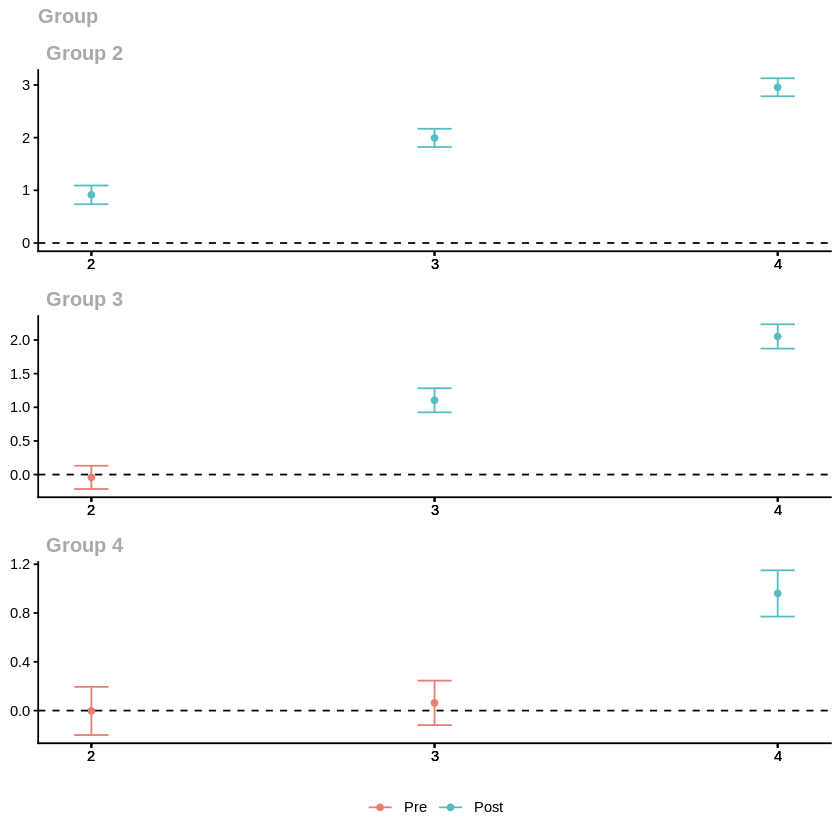

In [6]:
# Plot group-time average treatment effects
ggdid(example_attgt_dml_linear)

It's also possible to calculate aggregated effect estimates. Please note that, the results are again very close to those in [the original notebook](https://bcallaway11.github.io/did/articles/did-basics.html#aggregating-group-time-average-treatment-effects).

In [7]:
agg.simple <- aggte(example_attgt_dml_linear, type = "simple")
summary(agg.simple)


Call:
aggte(MP = example_attgt_dml_linear, type = "simple")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


    ATT    Std. Error     [ 95%  Conf. Int.]  
 1.6586        0.0363     1.5875      1.7297 *


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0


### Details on Predictive Performance

We can add an evaluation functionality to the wrapper to assess how the predictive performance from the linear and logistic regression differ from that of the random forest learner.

In [8]:
library(mlr3measures)

# Add a wrapper that computes the RMSE and accuracy for the nuisance components, can be customized by providing custom measures
eval_preds = function(y, d, predictions, params_names, custom_measures = NULL) {
  measures_res = list()

  if (!is.null(custom_measures)) {
    # Alternatively provide a named list with custom evaluation functions
    measure_funcs = list()
  } else {
    measure_funcs = list()
    measure_funcs[['ml_m']] = mlr3measures::acc
    measure_funcs[['ml_g0']] = mlr3measures::rmse
  }

  for (param_name in params_names) {
    preds = predictions[[param_name]][, 1, 1]

  if (param_name == "ml_m") {
    obs = d
    # map probability predictions to binary
    preds = as.factor(ifelse(preds > 0.5, 1, 0))
    obs = as.factor(preds)
  }

  else if (param_name == "ml_g0") {
    obs = y[d == 0]
    preds = preds[d == 0]
  }

  if (param_name == "ml_g1") {
    next
  }

  else {
    measure_func = measure_funcs[[param_name]]
    measure_pred = measure_func(obs, preds)

    measures_res[[param_name]] = measure_pred
  }

  }
    return(measures_res)
}

# evaluate learner performance: linear models
doubleml_did_eval_linear <- function(y1, y0, D, covariates,
  ml_g = lrn("regr.lm"),
  ml_m = lrn("classif.log_reg"),
  n_folds = 10, n_rep = 1, ...) {

  # warning if n_rep > 1 to handle mapping from psi to inf.func
  if (n_rep > 1) {
    warning("n_rep > 1 is not supported.")
  }
  # Compute difference in outcomes
  delta_y <- y1 - y0
  # Prepare data backend
  dml_data = DoubleML::double_ml_data_from_matrix(X = covariates, y = delta_y, d = D)
  # Compute the ATT
  dml_obj = DoubleML::DoubleMLIRM$new(dml_data, ml_g = ml_g, ml_m = ml_m, score = "ATTE", n_folds = n_folds)
  dml_obj$fit(store_predictions = TRUE)
  att = dml_obj$coef[1]
  # Return results
  inf.func <- dml_obj$psi[, 1, 1]

  # Evaluate learner performance
  predictions = dml_obj$predictions
  params_names = dml_obj$params_names()
  eval_predictions = eval_preds(delta_y, D, predictions, params_names)
  print(eval_predictions)

  output <- list(ATT = att, att.inf.func = inf.func)
  return(output)
  }

  library(mlr3measures)

# evaluate learner performance: random forest
doubleml_did_eval_rf <- function(y1, y0, D, covariates,
  ml_g = lrn("regr.ranger"),
  ml_m = lrn("classif.ranger"),
  n_folds = 10, n_rep = 1, ...) {

  # warning if n_rep > 1 to handle mapping from psi to inf.func
  if (n_rep > 1) {
    warning("n_rep > 1 is not supported.")
  }
  # Compute difference in outcomes
  delta_y <- y1 - y0
  # Prepare data backend
  dml_data = DoubleML::double_ml_data_from_matrix(X = covariates, y = delta_y, d = D)
  # Compute the ATT
  dml_obj = DoubleML::DoubleMLIRM$new(dml_data, ml_g = ml_g, ml_m = ml_m, score = "ATTE", n_folds = n_folds)
  dml_obj$fit(store_predictions = TRUE)
  att = dml_obj$coef[1]
  # Return results
  inf.func <- dml_obj$psi[, 1, 1]

  # Evaluate learner performance
  predictions = dml_obj$predictions
  params_names = dml_obj$params_names()
  eval_predictions = eval_preds(delta_y, D, predictions, params_names)
  print(eval_predictions)

  output <- list(ATT = att, att.inf.func = inf.func)
  return(output)
  }


In order to avoid name clashes, do not attach 'mlr3measures'. Instead, only load the namespace with `requireNamespace("mlrmeasures")` and access the measures directly via `::`, e.g. `mlr3measures::auc()`.



Running the evaluation wrappers helps to see that the random forest learner has a higher RMSE for predicting the outcome $E[\Delta Y|D=1,X]$. Both models predict individuals' treatment (group) status with an accuracy of $1$.

In [9]:
# Run estimation with evaluation: Linear model
set.seed(1234)
example_attgt_dml_eval_linear <- att_gt(yname = "Y",
                      tname = "period",
                      idname = "id",
                      gname = "G",
                      xformla = ~X,
                      data = dta,
                      est_method = doubleml_did_eval_linear,
                      print_details = TRUE)


summary(example_attgt_dml_eval_linear)



 Evaluating (g,t) = (2,1)$ml_g0
[1] 1.425103

$ml_m
[1] 1


 Evaluating (g,t) = (2,2)$ml_g0
[1] 1.409154

$ml_m
[1] 1


 Evaluating (g,t) = (2,3)$ml_g0
[1] 1.397313

$ml_m
[1] 1


 Evaluating (g,t) = (3,1)$ml_g0
[1] 1.425493

$ml_m
[1] 1


 Evaluating (g,t) = (3,2)$ml_g0
[1] 1.40676

$ml_m
[1] 1


 Evaluating (g,t) = (3,3)$ml_g0
[1] 1.421083

$ml_m
[1] 1


 Evaluating (g,t) = (4,1)$ml_g0
[1] 1.426055

$ml_m
[1] 1


 Evaluating (g,t) = (4,2)$ml_g0
[1] 1.40583

$ml_m
[1] 1


 Evaluating (g,t) = (4,3)$ml_g0
[1] 1.423951

$ml_m
[1] 1




Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    xformla = ~X, data = dta, est_method = doubleml_did_eval_linear, 
    print_details = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
     2    2   0.9145     0.0646        0.7368      1.0922 *
     2    3   1.9951     0.0631        1.8215      2.1687 *
     2    4   2.9561     0.0622        2.7850      3.1273 *
     3    2  -0.0418     0.0629       -0.2147      0.1312  
     3    3   1.1041     0.0651        0.9251      1.2830 *
     3    4   2.0533     0.0658        1.8725      2.2341 *
     4    2  -0.0028     0.0718       -0.2002      0.1946  
     4    3   0.0635     0.0663       -0.1188      0

In [10]:
# Run estimation with evaluation: Linear model
set.seed(1234)
example_attgt_dml_eval_rf <- att_gt(yname = "Y",
                      tname = "period",
                      idname = "id",
                      gname = "G",
                      xformla = ~X,
                      data = dta,
                      est_method = doubleml_did_eval_rf,
                      print_details = TRUE)


summary(example_attgt_dml_eval_rf)


 Evaluating (g,t) = (2,1)$ml_g0
[1] 1.571778

$ml_m
[1] 1


 Evaluating (g,t) = (2,2)$ml_g0
[1] 1.916236

$ml_m
[1] 1


 Evaluating (g,t) = (2,3)$ml_g0
[1] 2.404318

$ml_m
[1] 1


 Evaluating (g,t) = (3,1)$ml_g0
[1] 1.570486

$ml_m
[1] 1


 Evaluating (g,t) = (3,2)$ml_g0
[1] 1.529782

$ml_m
[1] 1


 Evaluating (g,t) = (3,3)$ml_g0
[1] 1.88629

$ml_m
[1] 1


 Evaluating (g,t) = (4,1)$ml_g0
[1] 1.570562

$ml_m
[1] 1


 Evaluating (g,t) = (4,2)$ml_g0
[1] 1.529405

$ml_m
[1] 1


 Evaluating (g,t) = (4,3)$ml_g0
[1] 1.560689

$ml_m
[1] 1




Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    xformla = ~X, data = dta, est_method = doubleml_did_eval_rf, 
    print_details = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
     2    2   0.9647     0.0698        0.7733      1.1562 *
     2    3   2.1055     0.0879        1.8643      2.3467 *
     2    4   3.1295     0.1056        2.8397      3.4192 *
     3    2   0.0820     0.0702       -0.1106      0.2747  
     3    3   1.2075     0.0704        1.0144      1.4006 *
     3    4   2.2865     0.0889        2.0428      2.5302 *
     4    2   0.1807     0.0713       -0.0149      0.3763  
     4    3   0.2451     0.0675        0.0599      0.430

### Acknowledgements and Final Remarks

We'd like to thank the authors of the `did` package for R for maintaining a flexible interface for multi-period DiD models.

We'd like to note that the implementation presented is here is very similar to the one implemented in the Python package. For more details, we would like to reference to the [DiD](https://docs.doubleml.org/stable/examples/index.html#difference-in-differences) examples in Python.

### References

Callaway, Brantly, and Pedro HC Sant’Anna. "Difference-in-differences with multiple time periods." Journal of Econometrics 225.2 (2021): 200-230.

Sant’Anna, Pedro HC, and Jun Zhao. "Doubly robust difference-in-differences estimators." Journal of Econometrics 219.1 (2020): 101-122.